# Music Genre Classification using an Audio Spectogram Transformer (a purely attention-based model) and Mel Spectograms


In this notebook, we will use an Audio Spectrogram model on music genre classification. We will use an already pre-built and pre-trained model from Hugging Face. However, we will modify it and train it according to our needs.

Documentation and info on the model can be found here - https://huggingface.co/docs/transformers/v4.46.0/en/model_doc/audio-spectrogram-transformer

## 0. Importing libraries, setting up device agnostic code

We start by importing the main needed libraries to run the script. Then we check the GPU properties and set up device agnostic code. In this manner, if a GPU is available, it will be used. Furthermore, we set a random seed so that a fixed seed will maintain consistency in experimental results. This will also make it easier to compare different approaches.

The AST model uses convolution layers in order to divide the input into patches. In the case of convolution layers, setting a random seed is not enough to create results that will be consistent no matter how many times one runs the notebook code. This is due to two settings in the backend code:
* `torch.backends.cudnn.deterministic`: Setting this bool to **True** will make the cuDNN (stands for CUDA Deep Neural Network library) to only use deterministic algorithms. However those algorithms are not always optimized and as a result, the code will run slower.
* `torch.backends.cudnn.benchmark`: Setting this bool to **True** will make the cuDNN to benchmark multiple convolution algorithms and select the fastest. This prevents us from having the same results every time we run the code. At the same time, it is obvious that it also affects speed.

In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torchaudio
import torch.nn as nn
from torchaudio.datasets import GTZAN
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchaudio.__version__)

ERROR! Session/line number was not unique in database. History logging moved to new session 121
2.7.0+cu118
2.7.0+cu118


In [2]:
# Set random seeds
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Only use deterministic convolution algorithms
torch.backends.cudnn.deterministic = True

# Turn off "benchmark of convolution algorithms and selecting the fastest", in order to have repeatability in the results
torch.backends.cudnn.benchmark = False

In [3]:
!nvidia-smi

Thu Nov 13 16:59:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.57                 Driver Version: 581.57         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX150         WDDM  |   00000000:02:00.0 Off |                  N/A |
| N/A   47C    P0            N/A  / 5001W |       0MiB /   2048MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Loading data

We load the data from the respective `.json` file in the current directory. The data is extracted using the `ASTFeatureExtractor`. As a result, it is already normalized according to the [AST paper](https://arxiv.org/pdf/2104.01778). Data is loaded as numpy arrays. Those arrays are used to create PyTorch tensors. We are also going to create a *classes* list in order to use the name of the classes for predictions later.

The AST model expect the following shape as input: `(batch_size, time_frames, mel_bands)`. To work with the pre-built AST model, those values should be:
* `time_frames`: 1024 -> This value is set by the way the AST model is trained.
* `mel_bands`: 128 -> This value is included in the AST paper.

As a result, our shape should be:  `(batch_size, time_frames, mel_bands)`. The shape we get from the `.json` file is already set to produce the following shape: `(time_frames, mel_bands)`. So, our size will be `(num_samples, time_frames, mel_bands)`. When the DataLoaders will be set, we will have `batch_size` instead of `num_samples` (the number of samples).

In [5]:
# Create function to load melspec data from json file
DATASET_PATH = "data_small_AST_hf.json"

def load_data(dataset_path):
    with open(dataset_path, 'r') as fp:
        data = json.load(fp)

    # Convert
    X = np.array(data['melspec'])
    y = np.array(data['labels'])

    return X, y

In [6]:
# Create function to load classes from json file
DATASET_PATH = "data_full_AST_hf.json"

def load_classes(dataset_path):
    with open(dataset_path, 'r') as fp:
        data = json.load(fp)
    classes = data['mapping']
    return classes

In [7]:
# Load classes
classes = load_classes(DATASET_PATH)
print(classes)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [8]:
# Load data
inputs, labels = load_data(DATASET_PATH)
inputs.shape, labels.shape

((3000, 1024, 128), (3000,))

In [9]:
# Turn data into tensors, to be ready for Transformer
X = torch.from_numpy(inputs).float() # weight calculations expect float
y = torch.from_numpy(labels).long() # CrossEntropyLoss expects long
X.shape, y.shape

(torch.Size([3000, 1024, 128]), torch.Size([3000]))

## 2. Create DataSets and DataLoaders

In order to use the data in our model, we have to organize it into PyTorch DataLoaders.
After loading the data, we split them into three sets: train_set, validation_set and test_set. The validation_set will be used during the training for evaluation. The test_set will be used after the model is ready. In order for it to be exposed in never seen data.

After dividing the sets, we create the respective datasets and dataloaders.

In [10]:
# Creating a function to divide the sets
def divide_sets(X, y, test_size, validation_size, random_state=None):

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, random_state=random_state)

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [11]:
# Create train, validation and test sets test size is 25% of the whole set. Validation size is 20% of the remaining train_set
X_train, X_validation, X_test, y_train, y_validation, y_test = divide_sets(X, y, test_size=0.25,
                                                                                validation_size=0.2,
                                                                                random_state=RANDOM_SEED)

In [12]:
# Check if data is divided correctly
print(X.shape[0] == X_train.shape[0] + X_validation.shape[0] + X_test.shape[0])
print(y.shape[0] == y_train.shape[0] + y_validation.shape[0] + y_test.shape[0])

True
True


In [13]:
# Create datasets and dataloaders
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE=32
torch.manual_seed(RANDOM_SEED)

train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
validation_dataloader = DataLoader(validation_dataset,
                                   batch_size=BATCH_SIZE,)
test_dataloader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of validation dataloader: {len(validation_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000028AE2B26310>, <torch.utils.data.dataloader.DataLoader object at 0x00000283A6CAE910>)
Length of train dataloader: 57 batches of 32
Length of validation dataloader: 15 batches of 32
Length of test dataloader: 24 batches of 32


In [14]:
# Checking the dataset shapes using test_dataset
test_features_batch, test_labels_batch = next(iter(test_dataloader))
print(test_features_batch.shape, "-> (batch_size, time_frames, mel_bands)")
print(test_labels_batch.shape, "-> (batch_size,) each entry is the class index of a sample")
print(test_features_batch[0].shape, "-> (time_frames, mel_bands))")
print(test_labels_batch[0], "-> (label)")

torch.Size([32, 1024, 128]) -> (batch_size, time_frames, mel_bands)
torch.Size([32]) -> (batch_size,) each entry is the class index of a sample
torch.Size([1024, 128]) -> (time_frames, mel_bands))
tensor(6) -> (label)


## 3. Data visualization

For better perception of the subject, we implement some visualization of the data. We use matplotlib libraries to visualize a Mel Spectogram of the first example. The data has to be turned into numpy arrays in order to be processed by matplotlib.
In the picture, the y axis has the mel banks. Usually this axis shows the frequency in order to be more user friendly. This is done by transposing the main frequency of each of the bank from mels to Hz. However we are not going to do that, as we are interested in the visual shape of the spectogram. But this means that one can view the y axis as a frequency axis and indeed we see the frequencies that appear in each sample. The samples are 10 sec long.

A second visualization is implemented later, in order to view various representations of different genres.

The music genre of each representation can also be viewed.


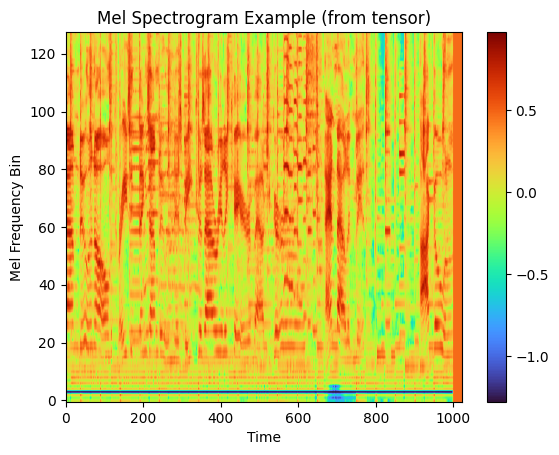

In [15]:
# Visualise data
np.random.seed(RANDOM_SEED)
INDEX = np.random.randint(len(X))
melspec_example = X[INDEX].numpy().T

plt.imshow(melspec_example, cmap='turbo', aspect='auto', origin='lower')
plt.colorbar()
plt.title("Mel Spectrogram Example (from tensor)")
plt.xlabel("Time")
plt.ylabel("Mel Frequency Bin")
plt.show()

A careful look on the spectrogram, shows a small vertical monochromous line towards its end. This appears due to the way the `ASTFeatureExtractor` from Hugging Face extracts the data. It exports a fixed sized Mel Spectrogram.

More precisely:

* The `ASTFeatureExtractor` requires a fixed sample rate size of 16000.
* The `ASTFeatureExtractor` creates tensors of size (batch_size, time_frames, mel_bands), where the value of the time_frames has to be 1024.
* The Audio Spectogram Transformer, in chapter 2.1 mentions that "the input audio waveform of t seconds is converted... computed with a 25ms Hamming window __every 10ms__". This means that the hop_size is 10ms.

Let's convert this value to a number of samples:
$\text{hop\_size} = \text{sample\_rate} \times \text{hop\_size\_duration} = 16000 \times 10 \times 10^{-3} = 160\,\text{samples}$.
This value can also be seen in line 131 of the [ASTFeatureExtractor source code](https://github.com/huggingface/transformers/blob/v4.46.0/src/transformers/models/audio_spectrogram_transformer/feature_extraction_audio_spectrogram_transformer.py#L39):
```python
fbank = spectrogram(
                ...
                hop_length=160,
                ...
            ).T
```

We know that time_frames = ⌈num_samples / hop_length⌉, and since the time_features value should be 1024 and the hop_length is 160, that means that num_samples = 163840.
**This is the fixed number of samples that our audio sample should have ideally.**

We can also calculate the amount of seconds that our audio sampe should have, since this is a more human friendly value:
duration = num_samples / sample_rate = 163840 / 16000 = 10,24 seconds.

That means that if the audio sample is less than 10,24 seconds, the remaining time_frames that would correspond to the time until the 10,24, will appear blank. Just like in the spectrogram.

It is no coinsidence that the vertical line appears after the 1000th time_frame. The exported time_frames value is fixed to 1024.

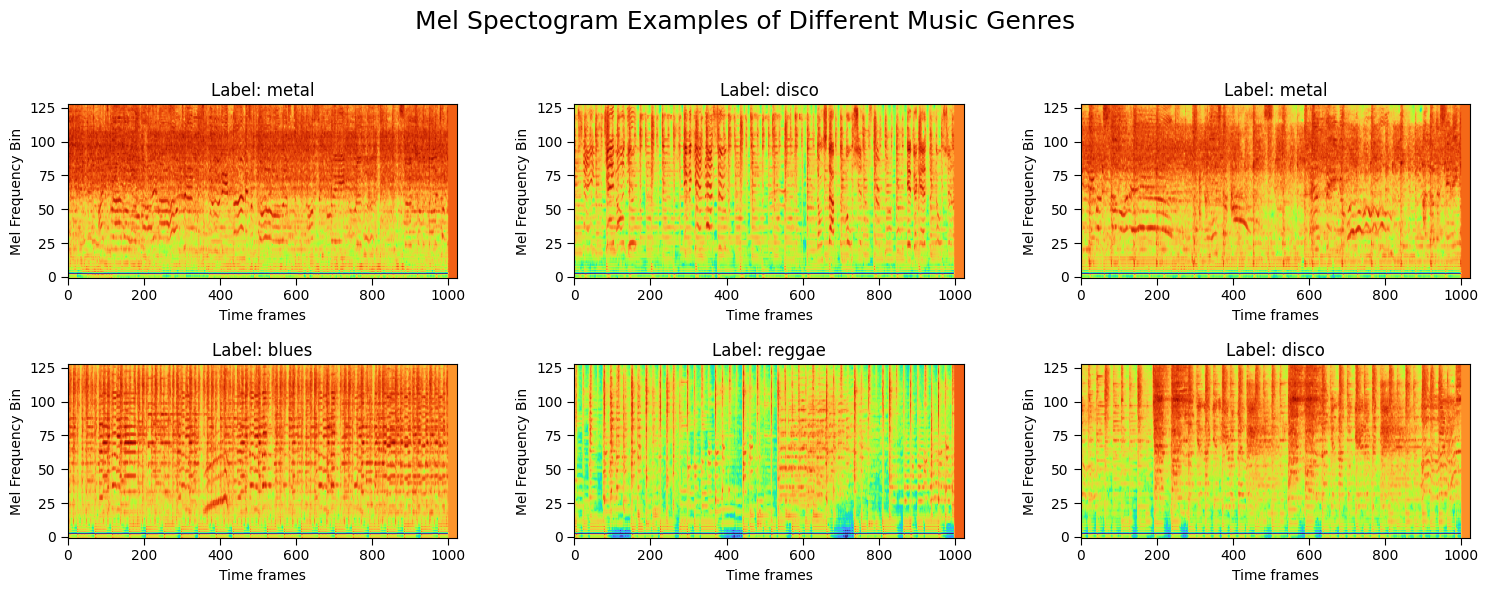

In [16]:
# Vizualize different genres
np.random.seed(RANDOM_SEED)
indices = np.random.choice(len(X), size=6, replace=False)

fig, axs = plt.subplots(2, 3, figsize=(15, 6),constrained_layout=False)
fig.suptitle("Mel Spectogram Examples of Different Music Genres", fontsize=18)

for i, idx in enumerate(indices):
    row = i // 3
    col = i % 3
    melspec_example = X[idx].numpy().T
    im = axs[row, col].imshow(melspec_example, cmap='turbo', aspect='auto', origin='lower')
    axs[row, col].set_title(f"Label: {classes[y[idx]]}")
    axs[row, col].set_xlabel("Time frames")
    axs[row, col].set_ylabel("Mel Frequency Bin")
    axs[row, col].tick_params(axis='both', which='both', length=5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

## 4. Using a pretrained AST model from Hugging Face

Instead of building the AST model, we can use an already built model. Hugging face is a site that can be a source for various models. Torchaudio also has a library of pre-built models. However, the AST model that we want to use is not included there.
To learn more about the AST model that we are going to use, check here - https://huggingface.co/docs/transformers/v4.46.0/en/model_doc/audio-spectrogram-transformer

In the same manner that we did when extracting data from the audio files, we follow the pipeline included in the [tutorial for using the AST model](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/AST/Inference_with_the_Audio_Spectogram_Transformer_to_classify_audio.ipynb) in order to build the model.

However in our case, we have to modify the classifier head in order to fit our needs. The original AST model from hugging face is trained for 527 different classes. However, our case only has 10 classes. So, we "freeze" the base layers and replace the output layer to suit our needs.

After creating the model, we present an overview using `summary()` from the `torchinfo` library.

>_In order to use the hugging face library, one must first run `pip install transformers` in the terminal, to download it._

In [17]:
# Setup an AST model instance with pretrained weights
from transformers import ASTForAudioClassification, ASTConfig

torch.manual_seed(RANDOM_SEED)

config = ASTConfig.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593"
)

model_0 = ASTForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593",
    config=config
)

# Freeze the base parameters
for param in model_0.parameters():
    param.requires_grad = False

# Update the classifier head
in_features = model_0.classifier.dense.in_features
out_features = len(classes)
model_0.classifier.dense = nn.Linear(in_features, out_features)

# Make the classifier head trainable
for param in model_0.classifier.parameters():
    param.requires_grad = True

# Put the model to GPU if available.
model_0 = model_0.to(device)
model_0

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTAttention(
            (attention): ASTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=T

In [18]:
# Overview of the model
from torchinfo import summary

summary(model=model_0,
        input_size=(1, 1024, 128),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
ASTForAudioClassification (ASTForAudioClassification)                  [1, 1024, 128]       [1, 10]              --                   Partial
├─ASTModel (audio_spectrogram_transformer)                             [1, 1024, 128]       [1, 768]             --                   False
│    └─ASTEmbeddings (embeddings)                                      [1, 1024, 128]       [1, 1214, 768]       933,888              False
│    │    └─ASTPatchEmbeddings (patch_embeddings)                      [1, 1024, 128]       [1, 1212, 768]       (197,376)            False
│    │    └─Dropout (dropout)                                          [1, 1214, 768]       [1, 1214, 768]       --                   --
│    └─ASTEncoder (encoder)                                            [1, 1214, 768]       [1, 1214, 768]       --                   False
│    │    └─Modul

In [19]:
# extract sample data
# Extracting a sample
melspec, _ = next(iter(train_dataloader))
melspec.shape, melspec[0].shape

(torch.Size([32, 1024, 128]), torch.Size([1024, 128]))

In [20]:
# Pass sample data through the model
model_0(melspec[0].unsqueeze(0).float().to(device))

SequenceClassifierOutput(loss=None, logits=tensor([[-0.2217, -0.6126, -0.5414,  0.2247,  0.9996,  0.8957, -1.0515,  0.0372,
         -0.1658,  0.2001]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

## 5. Training the model
We start by setting a loss function and an optimizer. Two crucial elements of the training procedure.

In order to implement the training pipeline, we will create two separate functions:
* `train_step()`: This function is responsible for the training of the model. It also includes the logic for calculating the accuracy. We could use `torchmetrics.accuracy()`, but instead one can calculate it. We use the `argmax()` method after applying a `softmax()` on the logits that are extracted from the model. This calculation gives us the predicted label, because it returns the index of the highest probability. After that, the accuracy is calculated as the sum of predicted labels that are the same as the labels, divided by the number of samples.
* `test_step()`: This function will evaluate the loss and accuracy on a set. Initially we will use it on the evaluation set during training.

Those two functions are combined in the `train()` function in order to train the model for a set number of epochs. We also use the `timeit` library to set a timer in order to time the training. The `train()` function returns a dictionary with the results, in order to use them for plotting.

The model's ouput is not logits directly. Instead, it is an object of class `SequenceClassifierOutput`. This object has the attribute `logits` which is what we need to calculate the loss and accuracy.

In [21]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.0001,
                             weight_decay=0.0001)

In [22]:
# Create a train loop function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        outputs = model(X)
        y_pred = outputs.logits

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [23]:
# Create test loop function
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            outputs = model(X)
            test_pred_logits = outputs.logits

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [24]:
# Create train function by combining train_step and test_step
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [25]:
# Training model_0
# Set number of epochs
NUM_EPOCHS = 15

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=validation_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9665 | train_acc: 0.3838 | test_loss: 1.6891 | test_acc: 0.5563
Epoch: 2 | train_loss: 1.2802 | train_acc: 0.7209 | test_loss: 1.2417 | test_acc: 0.6813
Epoch: 3 | train_loss: 0.9430 | train_acc: 0.7791 | test_loss: 0.9943 | test_acc: 0.7229
Epoch: 4 | train_loss: 0.7746 | train_acc: 0.8163 | test_loss: 0.8668 | test_acc: 0.7458
Epoch: 5 | train_loss: 0.6658 | train_acc: 0.8388 | test_loss: 0.7800 | test_acc: 0.7729
Epoch: 6 | train_loss: 0.6086 | train_acc: 0.8492 | test_loss: 0.7221 | test_acc: 0.8083
Epoch: 7 | train_loss: 0.5519 | train_acc: 0.8640 | test_loss: 0.6808 | test_acc: 0.8125
Epoch: 8 | train_loss: 0.5125 | train_acc: 0.8690 | test_loss: 0.6439 | test_acc: 0.8208
Epoch: 9 | train_loss: 0.4817 | train_acc: 0.8728 | test_loss: 0.6216 | test_acc: 0.8313
Epoch: 10 | train_loss: 0.4623 | train_acc: 0.8810 | test_loss: 0.5983 | test_acc: 0.8333
Epoch: 11 | train_loss: 0.4407 | train_acc: 0.8810 | test_loss: 0.5769 | test_acc: 0.8292
Epoch: 12 | train_l

## 6. Plotting the results of the AST model

We define a helper function named `plot_loss_curves()` to plot the results. We then use matplotlib to see how our model performed.

In [26]:
# Define a plotting function
from typing import Tuple, Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

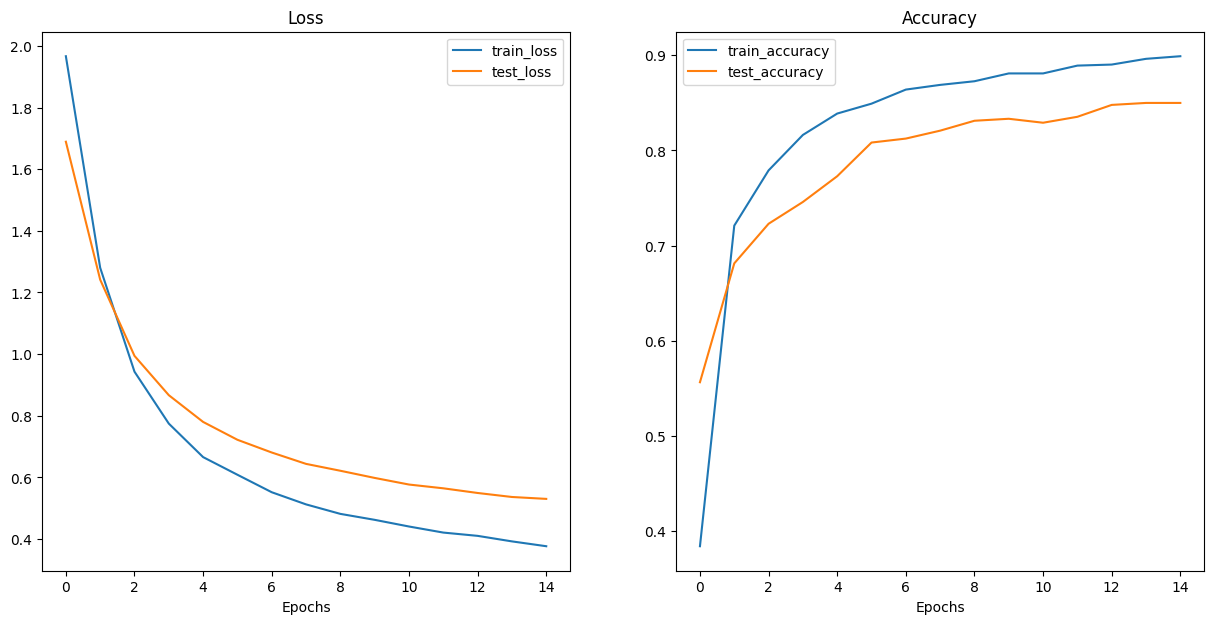

In [27]:
# Plotting the results of model_0
plot_loss_curves(model_0_results)

## 7. Evaluating our model on never seen data

Finally, we are going to use the `test_dataloader` to evaluate our model.

In [28]:
# Evaluate the AST on the test set
evaluation = test_step(model=model_0,
                       dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       )
print(f"test loss = {evaluation[0]:.4f} | test acc = {evaluation[1]:.4f}")

test loss = 0.4505 | test acc = 0.8501


## 8. Creating a `predict()` function, to make predictions on unseen data

We are going to use our transformer model to make predictions. First we use the test dataloader to extract the first sample. Then we create the predict function that among other arguments, we can enter the index of the sample we want to predict. We see that we have 750 indexes available.
The tensor that represents the sample has to be unsqueezed because the model expects a `batch_size` on dim=0. The model exports logits. Using `softmax()` we turn the logits into probabilities and with `argmax()` we take the index of the highest probability. This is actually the predicted index class. However, we can use `argmax()` right away without having the probabilites first. This is because logit values are respective to the probability values. This is actually the predicted index class. We also do that for time complexity reasons.

Changing the `model` and `index` arguments on the `predict()` function can let us make further testing.

In [29]:
# Creating the predict() function
def predict(model: torch.nn.Module,
            X_test: torch.Tensor,
            y_test: torch.Tensor,
            index: int = 0,
            device: str = "cpu",
            classes: list = classes):

    X_sample = X_test[index].unsqueeze(0).to(device)
    y_sample = y_test[index].item() if isinstance(y_test[index], torch.Tensor) else y_test[index]

    model.eval()
    with torch.inference_mode():
        outputs = model(X_sample)
        logits = outputs.logits
        predicted_index = torch.argmax(logits, dim=1).item()

    print(f"Target: {classes[y_sample]}, Predicted label: {classes[predicted_index]}")

In [30]:
# Printing the shape to see how many indexes we have
X_test.shape

torch.Size([750, 1024, 128])

In [31]:
# Set random seed to define index.
np.random.seed(RANDOM_SEED) # remove this line to set a random index, for further testing
index = np.random.randint(len(X_test))
predict(model=model_0,
        X_test=X_test,
        y_test=y_test,
        index=index,
        device=device,
        classes=classes)

Target: country, Predicted label: country


## 9. Making a confusion matrix for further evaluation

For a good vizualization of our model's performance, we can use a confusion matrix for `model_0`. For that purpose we will use the `torchmetrics` and `mlxtend` library.
First we will make predictions on a test set and save the results on a tensor. Then we can use this tensor along with `y_test` which is a tensor containing the correct values for the labels of the test set.

In [32]:
# Importing libraries
import mlxtend
print(f"mlxtend version: {mlxtend.__version__}")
assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher. use pip install -q torchmetrics -U mlxtend"

mlxtend version: 0.23.4


In [33]:
# Make predictions on test_set and get tensor with predictions
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    outputs = model_0(X)
    y_logit = outputs.logits
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/24 [00:00<?, ?it/s]

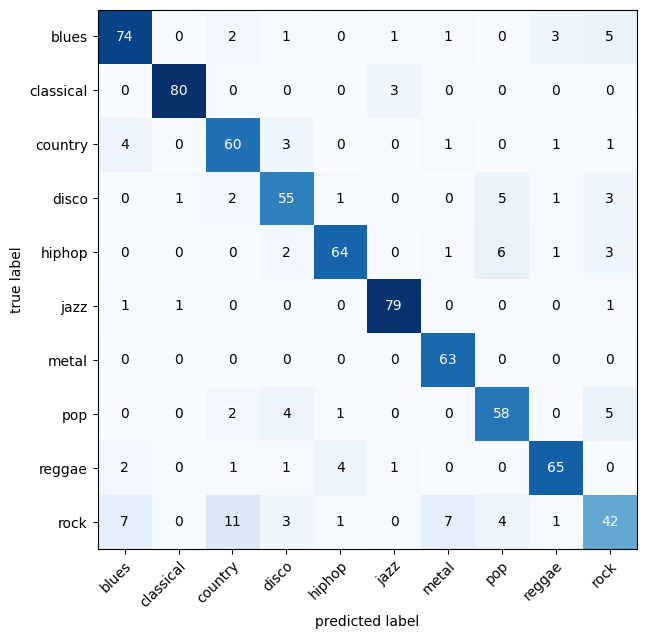

In [34]:
# Importing libraries
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(classes), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_test)

#  Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=classes, # turn the row and column labels into class names
    figsize=(10, 7)
);

We can see that our model performs quite well. One of the benefits of the confusion matrix, is that we can see what labels our model mismatches. We can see that the the genres that are most likely to be mismatched are rock and country. This is interesting, because those genres could be easily mismatched by a human as well, cause there are similar with rock or blues. We do not see that much errors in distinguishing that many genres for classical. Furthermore, one must bear in mind that the distinction of genres is based on audio features. As a result, one can expect mismatches genres that use similar instruments or music production.